# Home Assignment No. 2: Practice

To solve this task efficiently, here are some practical suggestions:

* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember to use tutorials, lecture slides, and other resources.


* Instead of rewriting existing code try to use **BUILT-IN METHODS** available in the libraries.


* To complete this part of the homework, you have to write some **CODE** directly inside the specified places in the notebook **CELLS**.


* In some problems you are asked to provide a short discussion of the results. In these cases you have to create a **MARKDOWN** cell with your comments right after the corresponding code cell.


* For every separate problem, you can get **INTERMEDIATE scores**.


* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if a reviewer executes your code, the output will be the same (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.


* Your code must be readable. For this purpose, try to include **necessary** (and not more) comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY**.


* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameter and set it to `-1` to use all the cores.


* In the end you need to hand in a **single zip file** containing **two notebooks** (theory and practice) as well as the **html exported version** of this notebook.


To begin let's import the essential (for this assignment) libraries.

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Linear SVM (face detection)

In this part you will need to implement a linear SVM classifier via the gradient descent algorithm.

First, let us have a look at the data we want to train our algorithm on.

In [ ]:
# Load the faces data
data = loadmat('faces.mat')
labels = np.squeeze(data['Labels'])
data = data['Data']

Let us visualize some examples from the dataset. The dataset contains a set of $24 \times 24$ grayscale images labeled as face/non-face. Our goal is to train a classifier on this data. For calculations we will treat the samples as flattened vectors, the same way as they are stored. For visualization one needs to reshape the samples to $24 \times 24$ images.

In [ ]:
# Visualize some examples from the dataset.
samples_per_class = 10
classes = [-1, 1]
train_imgs = np.reshape(data, [-1, 24, 24], order='F')

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(labels, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

## Task 1: SVM loss function [6 points]

In the lectures we have seen the SMO algorithm, which works in the dual domain. In this assignment we explore **Pegasos**, an optimization algorithm in the primal domain.

Recall the formulation of the SVM optimization problem as follows:

\begin{aligned}
& \min_{w, b}
& & \frac{1}{2}||w||^2 + C\sum_{i=1}^m \xi_i \\
& \ \text{ s.t.}
& & y^{(i)}(w^Tx^{(i)}+b) \geq 1-\xi_i, \; i = 1, \ldots, m \\
& & & \xi_i \geq 0, \; i = 1, \ldots, m \\
\end{aligned}

Let $f(x)=w^Tx+b$. The constraints can then be written as $y^{(i)}f(x^{(i)})\geq 1-\xi_i$. Together with the constraints $\xi_i \geq 0$ this leads to $\xi_i=\max(0, 1-y^{(i)}f(x^{(i)}))$. The above constraint optimization problem is therefore equivalent to the following **unconstrained** problem:

\begin{equation}
\min_{w, b} \frac{\lambda}{2}||w||^2 + \frac{1}{m}\sum_{i=1}^m \max(0, 1-y^{(i)}f(x^{(i)}))
\end{equation}

The first term in this objective is a regularization term (prevents overfitting) and the second term measures the classification loss. Here the parameter $\lambda=1/C$ is a **hyper-parameter** that controls the relative weight of  both losses.


**TODO**: Implement the **unconstrained** objective function for SVM in the following *svm_loss* function according to the specifications.

***HINT***: Write a small test for the provided values of w, b and C. Make sure your function passes the test.

In [1]:
import numpy as np
np.random.seed(42) 

In [69]:
def svm_loss(w, b, X, y, lambda_):
    """
    Computes the loss of a linear SVM w.r.t. the given data and parameters

    Args:
        w: Parameters of shape [num_features]
        b: Bias (a scalar)
        X: Data matrix of shape [num_data, num_features]
        y: Labels corresponding to X of size [num_data, 1]
        lambda_: Regularization hyper-parameter

    Returns:
        l: The value of the objective for a linear SVM

    """

    #######################################################################
    # TODO:                                                               #
    # Compute and return the value of the unconstrained SVM objective     #
    #                                                                     #
    #######################################################################
    
    scores = np.dot(X, w) + b
    margins = np.maximum(0, 1 - y * scores)
    loss = np.mean(margins) + lambda_ * np.sum(w * w)


    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return loss



In [11]:
# Test your cost-function
import numpy as np 
np.random.seed(42) 
data = np.random.randn(5, 3)
labels = np.random.choice([-1, 1], 5).reshape(-1, 1) 
w_0 = np.zeros(data.shape[1])
b_0 = 0.
l_0 = svm_loss(w_0, b_0, X=data, y=labels, lambda_=1.)

#######################################################################
# TODO:                                                               #
# What should be the expected output of svm_loss with the given params#
                                                                #
#######################################################################


expected_output = 1.0

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

assert np.allclose(l_0, expected_output), "Something is wrong"
print("Well done!")

Well done!


## Task 2: SVM gradient [9 points]

**TODO**: Implement the gradient of the above unconstrained objective w.r.t. to the parameters $w$ and $b$. The gradient will be computed on a mini-batch (i.e., a random subset of the training set).

**Hint**: Don't worry about the fact that $\max(0, 1-y^{(i)}f(x^{(i)}))$ is not differentiable at $1-y^{(i)}f(x^{(i)})=0$. Just pick a one-sided gradient (this is called a subgradient for convex functions).

In [70]:
def svm_gradient(w, b, x, y, lambda_):
    """
    Compute gradient for SVM w.r.t. to the parameters w and b on a mini-batch (x, y)

    Args:
        w: Parameters of shape [num_features]
        b: Bias (a scalar)
        x: A mini-batch of training example [k, num_features]
        y: Labels corresponding to x of size [k]
        lambda_: Regularization hyper-parameter

    Returns:
        grad_w: The gradient of the SVM objective w.r.t. w of shape [num_features]
        grad_v: The gradient of the SVM objective w.r.t. b of shape [1]

    """

    #######################################################################
    # TODO:                                                               #
    # Compute the gradient for a particular choice of w and b.            #
    # Compute the partial derivatives and set grad_w and grad_b to the    #
    # partial derivatives of the cost w.r.t. both parameters in theta     #
    #                                                                     #
    #######################################################################
    y = y.ravel()
    k = x.shape[0]
    scores = np.dot(x, w) + b
    margins = 1 - y * scores

    # gradients
    valid_margin = margins > 0
    delta = np.zeros_like(y)
    delta[valid_margin] = -y[valid_margin]

    grad_w = np.dot(delta, x) / k + 2 * lambda_ * w
    grad_b = np.mean(delta)

    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return grad_w, grad_b

In [71]:
# Test your implementation
x_ = np.ones([2, 10])
y_ = np.array([1, -1])
w_0 = np.zeros(10)
b_0 = 0.
grad_w, grad_b = svm_gradient(w_0, b_0, x_, y_, 1.)

#######################################################################
# TODO:                                                               #
# What should be the expected output of svm_gradient                  #
# with the given params                                               #
#                                                                     #
#######################################################################

expected_grad_w = -np.mean(y_[:, np.newaxis] * x_, axis=0)
expected_grad_b = -np.mean(y_)

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################

assert np.allclose(grad_w, expected_grad_w), "Something is wrong"
assert np.allclose(grad_b, expected_grad_b), "Something is wrong"
print("Well done!")

Well done!


## Task 3: SVM Solver [18 points]

You will implement the **Pegasos** algorithm - a variant of SGD - to solve for the parameters $w$ and $b$. 

The algorithm was introduced in the following [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf) (see Figure 2). It is essentially Stochastic Gradient Descent on mini-batches + a specific choice for the learning rate giving convergence guarantees. The required steps are outlined in the following class implementation. For more details, please refer to the [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf).

**TODO**: Implement the Pegasos algorithm according to specs. Tune the hyper-parameter **C** to get at least 90% accuracy on test.

In [72]:
class LinearSVM:
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.w = None
        self.b = None
        
    def fit(self, X, y, num_iter=30000, num_per_batch=100, verbose=False):
        """
        Pegasos SVM solver.

        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]
            num_iter: Number of iterations
            num_per_batch: Number of samples per mini-batch

        Returns:
            theta: The value of the parameters after training

        """

        self.w = np.zeros(X.shape[1])
        self.b = 0.
        for t in range(1, num_iter + 1):
            start = time.time()
            
            #######################################################################
            # TODO:                                                               #
            # Perform one step of stochastic gradient descent:                    #
            #   - Select a single training batch at random                        #
            #   - Update theta based on alpha and using gradient_function         #
            #                                                                     #
            #######################################################################
            
            # 1st Step: Sample a random mini-batch of size num_per_batch
            indices = np.random.choice(X.shape[0], num_per_batch)
            X_batch = X[indices]
            y_batch = y[indices]
            # 2nd Step: Compute the learning-rate n_t=1/(lambda*t)
            n_t = 1 / (self.lambda_ * t )

            # 3rd Step: Compute the gradients and update the parameters as
            grad_w, grad_b = svm_gradient(self.w, self.b, X_batch, y_batch, self.lambda_)

            #update 
            self.w -= n_t * grad_w
            self.b -= n_t * grad_b

            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
            
            if verbose and t % 5000 == 0:
                exec_time = time.time() - start
                loss = svm_loss(self.w, self.b, X, y, self.lambda_)
                print(f'Iter {t}/{num_iter}: cost = {loss}  ({exec_time}s)')

    def predict_score(self, X):
        """
        Predicts a score for each sample (how confident the prediction is)
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train] - real numbers
        """
        #######################################################################
        # TODO:                                                               #
        # Write a function that predicts the "score" (condifence) for each    #
        # sample:                                                             #
        #                                                                     #
        #######################################################################
        
        preds = np.dot(X, self.w) + self.b

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################

        return preds                
                
    def predict(self, X):
        """
        Predicts class labels on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train]
        """
        #######################################################################
        # TODO:                                                               #
        # Write a function that predicts the class label {-1, 1} given the    #
        # data matrix X and trained params w and b. Use predict_score method  # 
        #                                                                     #
        #######################################################################
        scores = self.predict_score(X)
        preds = np.sign(scores)

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################

        return preds
    
    def score(self, X, y):
        """
        Calculates accuracy of the model on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Model's accuracy score.
        """

        #######################################################################
        # TODO:                                                               #
        # Write a functions that calculates the performance of the model on X #
        # in terms of accuracy                                                #
        #                                                                     #
        #######################################################################
        predictions = self.predict(X)
        score = np.mean(predictions == y)

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
        
        return score

Now we are going to train the model. First let's split the data into train and test sets and normalize them.

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

In [92]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [93]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (3, 3)
Training labels shape:  (3, 1)
Test data shape:  (2, 3)
Test labels shape:  (2, 1)


Now let us create a classifier instance and **fit** in on the training data.

In [95]:
import time
# We will measure the execution time
start = time.time()

C = 0.02
lambda_ = 1/C
my_svm = LinearSVM(lambda_=lambda_)
my_svm.fit(X_train, y_train, num_iter=30000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 5000/30000: cost = 0.9848149381241795  (0.0s)
Iter 10000/30000: cost = 0.9832890341995604  (0.0s)
Iter 15000/30000: cost = 0.9823927709412617  (0.0s)
Iter 20000/30000: cost = 0.9817526021222557  (0.0s)
Iter 25000/30000: cost = 0.9812537774174312  (0.0s)
Iter 30000/30000: cost = 0.9808527927901148  (0.0s)
Total exection time: 3.2770023345947266s


 We can have a look at what theta has learned to recognise as "face"

In [96]:
print("Shape of learned weights:", my_svm.w.shape)

Shape of learned weights: (3,)


In [80]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(my_svm.w, [24, 24], order='F'))
plt.title('Learned w')
plt.show()

ValueError: cannot reshape array of size 3 into shape (24,24)

Make the predictions, calculate the accuracy. Tune the hyperparameter C to get at least **90%** accuracy on the test!

In [97]:
print('Found C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test, y_test)))

Found C = 0.02, lambda = 50.0
Accuracy train: 0.6666666666666666
Accuracy test: 0.5


## Task 4: Multiclass classification [12 points]

SVM is designed to solve a binary classification problem. What if we want to solve _multiclass classification_, meaning that we want to classify sample in 1 to K labels (with K>2)?

We can still use binary SVM to solve this problem in a _one-vs-all_ manner, meaning that we can train _K_ binary classifiers distinguishing class $k$ vs the rest of the classes.

You will implement multiclass classification using your LinearSVM implementation as follows:
1. Initialize MulticlassLinearSVM with _K_ LinearSVMs
2. For each _k=1..K_ labels:  
    a. Convert multiclass labels into binary labels: _y==1_ if _target==k_, _y==-1_ if _target!=k_  
    b. Train a binary classifier with this labels
3. To predict a label for an unknown sample:  
    a. Get a prediction score for each binary classifier  
    b. Return the label for which the score is the highest

**TODO**: Implement the multiclass SVM.

In [98]:
class MulticlassLinearSVM:
    def __init__(self, lambda_, K_classes):
        self.lambda_ = lambda_
        self.K_classes = K_classes
        #######################################################################
        # TODO:                                                               #
        # Initialize the class with K_classes instances of LinearSVM          #
        #######################################################################
        self.classifiers = [LinearSVM(lambda_) for _ in range(K_classes)]
        
        
    def fit(self, X, y, num_iter=30000, num_per_batch=100, verbose=False):
        """
        Fit K classifiers

        Args:
            X: Data matrix of shape [num_train, num_features]
            y: Labels corresponding to X of size [num_train]; values from 0..K_classes-1
            num_iter: Number of iterations
            num_per_batch: Number of samples per mini-batch


        """

        #######################################################################
        # TODO:                                                               #
        # Train K_classes binary classifiers                                  #
        #   - Convert integer labels 0..K-1 to binary labels 1 / -1 for a given #
        #     binary classifier                                               #
        #   - Train the current binary classifier                             #
        #                                                                     #
        #######################################################################
        
        for k in range(0, self.K_classes):
            start = time.time()
            
            current_classifier = self.classifiers[k]
            
            #######################################################################
            # TODO:                                                               #
            # Convert multiclass labels y to binary labels classifying            #
            # y_bin = 1  if y==k vs y!=k                                          #
            # y_bin = -1 if y!=k vs y!=k                                          #
            #######################################################################
            y_bin = np.where(y == k, 1, -1)


            
            #######################################################################
            # TODO:                                                               #
            # Train the binary classifier with the converted labels               #
            # Don't forget to use this method's arguments                         #
            #######################################################################
            
            self.classifiers[k].fit(X, y_bin, num_iter, num_per_batch, verbose)
            if verbose:
                exec_time = time.time() - start
                print(f'Classifier {k+1}/{self.K_classes}: time ({exec_time}s)')
            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
            
            exec_time = time.time() - start
            print(f'Classifier {k+1}/{self.K_classes}: time ({exec_time}s)')
    
    def predict(self, X):
        """
        Predicts class labels on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Predictions of shape [num_train] in {0..K_classes-1}
        """
        #######################################################################
        # TODO:                                                               #
        # Write a function that predicts the class label {0, .., K_classes-1} #
        # Predict the score for every binary classifier (use predict_score)   #
        # Return the label for which the classifier gives the greatest score  #
        #                                                                     #
        #######################################################################       
        scores = np.array([classifier.predict_score(X) for classifier in self.classifiers])
        preds = np.argmax(scores, axis=0)

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################

        return preds
    
    def score(self, X, y):
        """
        Calculates accuracy of the model on X.
        
        Args:
            X: Data matrix of shape [num_train, num_features]
            
        Returns:
            Model's accuracy score.
        """

        #######################################################################
        # TODO:                                                               #
        # Write a functions that calculates the performance of the model on X #
        # in terms of accuracy                                                #
        #                                                                     #
        #######################################################################
        predictions = self.predict(X)
        score = np.mean(predictions == y)
        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
        
        return score

### Simple (non-exhaustive) test
The code below should execute without errors and give ~25% accuracy

In [101]:
C = 10.0
lambda_ = 1/C

n_classes = 4
n_samples = 2000
data_random = np.random.randn(n_samples, 2)
labels_random = np.array([np.random.randint(n_classes) for i in range(n_samples)])

mc_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=n_classes)
mc_svm.fit(data_random, labels_random, num_iter=1000, num_per_batch=64, verbose=True)

pred = mc_svm.predict(data_random)
print('Accuracy: ', mc_svm.score(data_random, labels_random))

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Classifier 1/4: time (0.10905075073242188s)
Classifier 1/4: time (0.10905075073242188s)
Classifier 2/4: time (0.10079169273376465s)
Classifier 2/4: time (0.10079169273376465s)
Classifier 3/4: time (0.1179654598236084s)
Classifier 3/4: time (0.11896181106567383s)
Classifier 4/4: time (0.1185770034790039s)
Classifier 4/4: time (0.1185770034790039s)
Accuracy:  0.2575
Total exection time: 322.52825450897217s


## Classification on FashionMNIST dataset
We'll train a multiclass SVM on FashionMNIST dataset, containing $28\times28$ grayscale images of 10 categories of clothing.  
Let's load and visualize the dataset

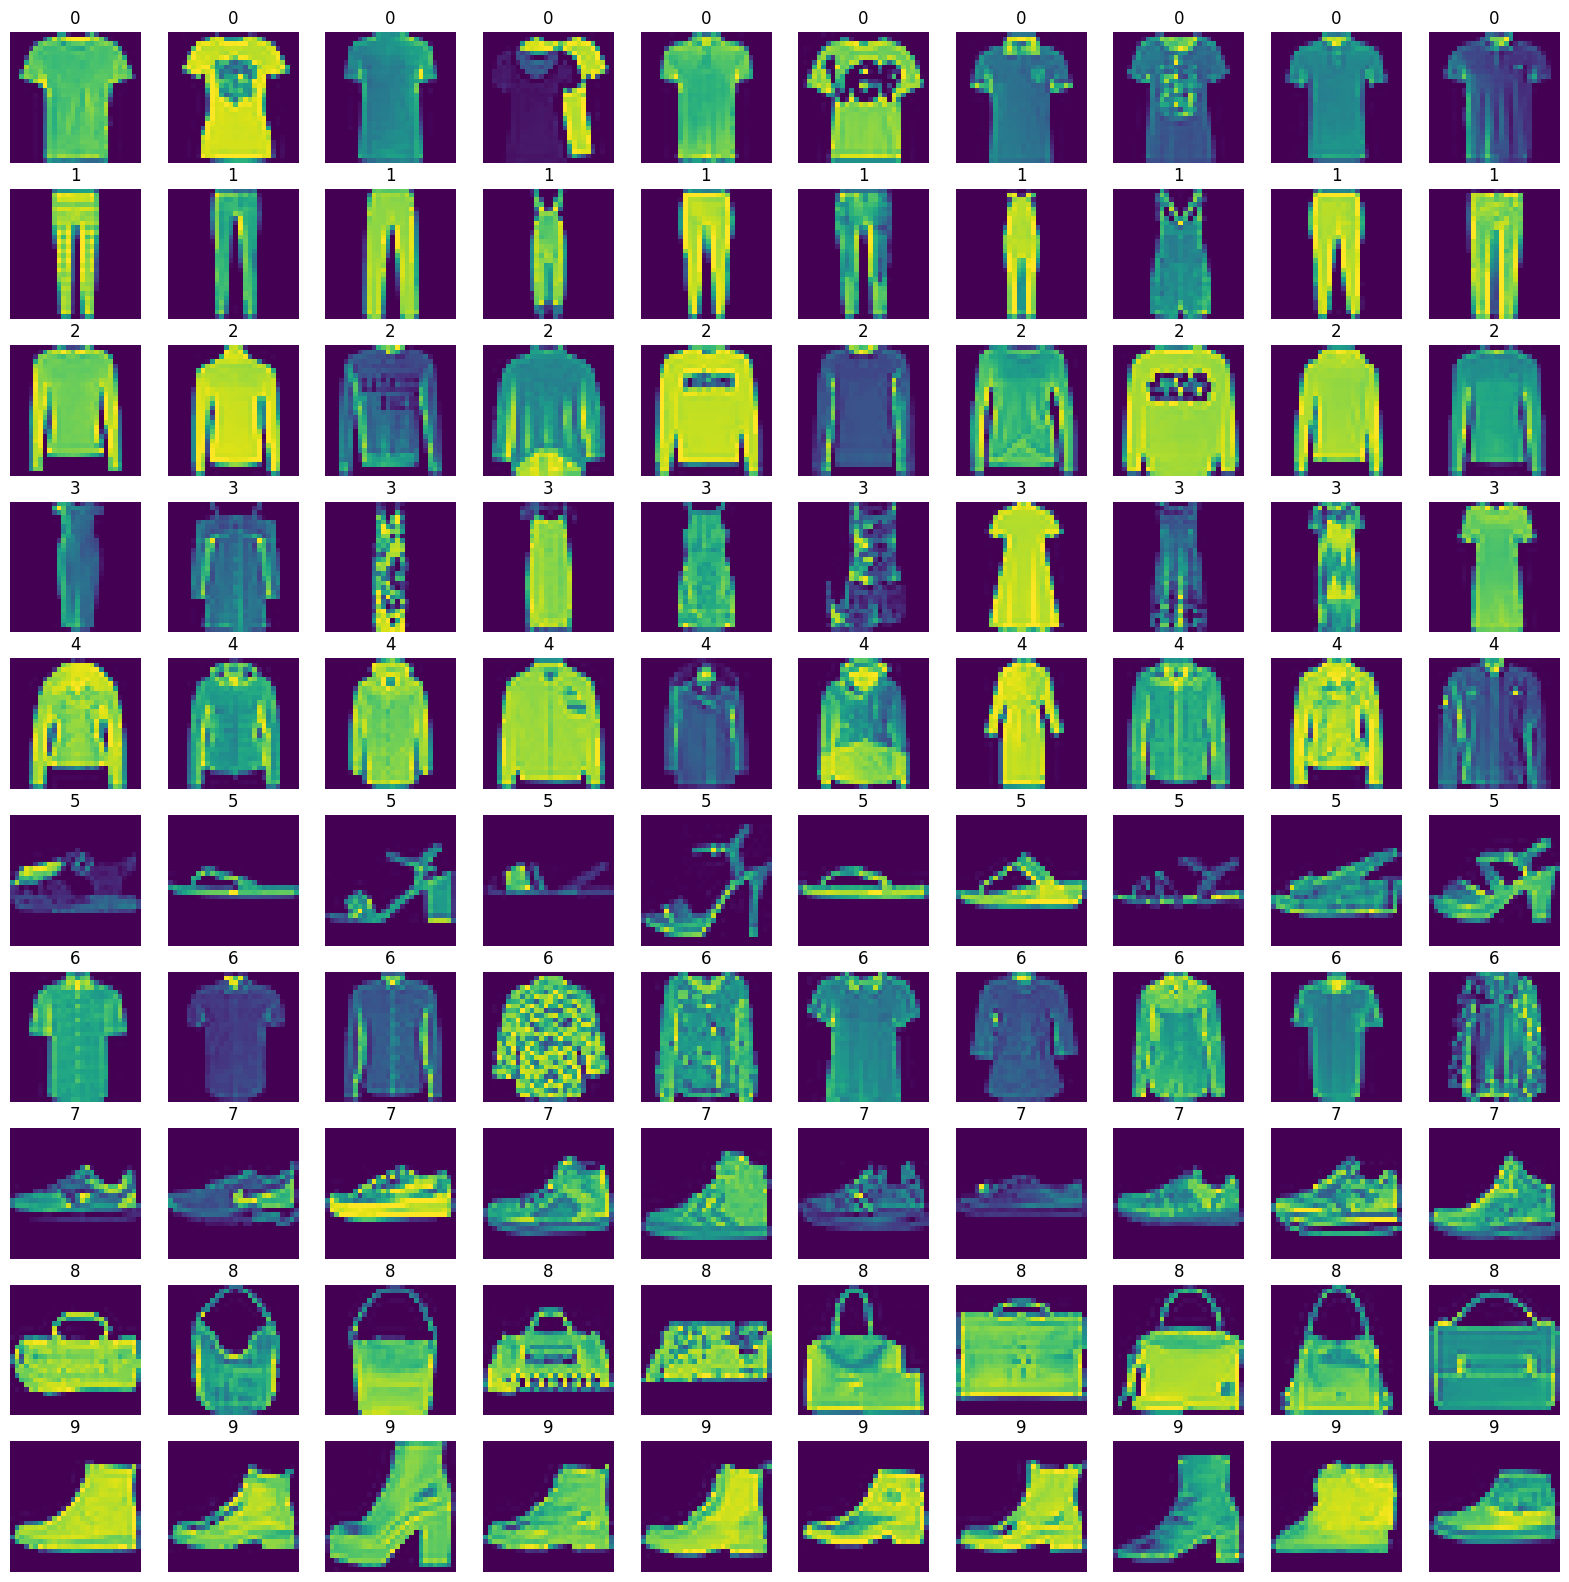

In [102]:
fmnist_data = np.load('fashion_mnist.npz')
X_train, X_test, y_train, y_test = fmnist_data['x_train'], fmnist_data['x_test'], fmnist_data['y_train'], fmnist_data['y_test']

# Visualize some examples from the dataset.
samples_per_class = 10
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_imgs = np.reshape(X_train, [-1, 28, 28], order='F')

plt.figure(figsize=(20,20))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(y_train, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

Now let's normalize the data, train the model and visualize the weights for each classifier

In [103]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
C = 0.01
lambda_ = 1./C
my_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=10)

my_svm.fit(X_train_scaled, y_train, num_iter=10000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 5000/10000: cost = 0.920951733460465  (0.0s)
Iter 10000/10000: cost = 0.9165217092017466  (0.0s)
Classifier 1/10: time (4.164200067520142s)
Classifier 1/10: time (4.164200067520142s)
Iter 5000/10000: cost = 0.9089094548581939  (0.0s)
Iter 10000/10000: cost = 0.9044670320175683  (0.0s)
Classifier 2/10: time (4.812387704849243s)
Classifier 2/10: time (4.812387704849243s)
Iter 5000/10000: cost = 0.9237271208157  (0.0s)
Iter 10000/10000: cost = 0.9192813380612901  (0.0s)
Classifier 3/10: time (4.634462356567383s)
Classifier 3/10: time (4.634462356567383s)
Iter 5000/10000: cost = 0.9216550288940867  (0.0s)
Iter 10000/10000: cost = 0.9171983115187204  (0.0s)
Classifier 4/10: time (3.9146766662597656s)
Classifier 4/10: time (3.9146766662597656s)
Iter 5000/10000: cost = 0.9218646394463971  (0.0s)
Iter 10000/10000: cost = 0.917427431273377  (0.0s)
Classifier 5/10: time (4.1330344676971436s)
Classifier 5/10: time (4.1330344676971436s)
Iter 5000/10000: cost = 0.9084868388659241  (0.0s)
Iter 

In [105]:
print('C = {}, lambda = {}'.format(C, lambda_))
print('Accuracy train: {}'.format(my_svm.score(X_train_scaled, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test_scaled, y_test)))

C = 0.01, lambda = 100.0
Accuracy train: 0.6469583333333333
Accuracy test: 0.6466944444444445


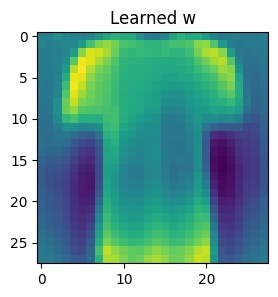

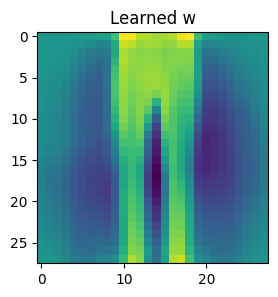

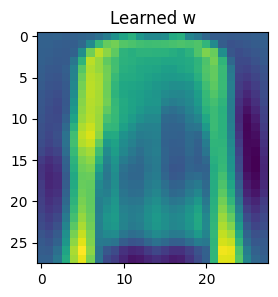

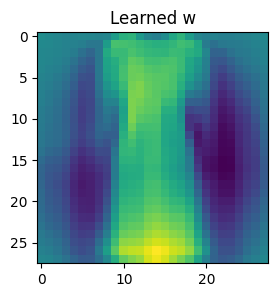

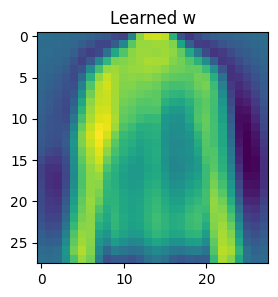

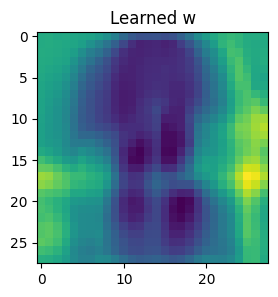

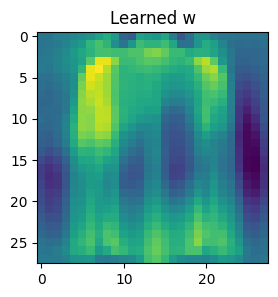

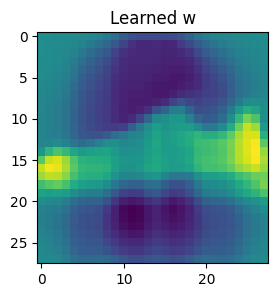

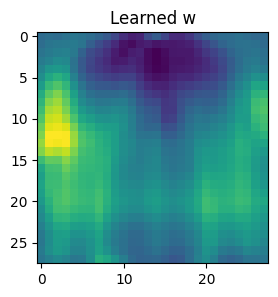

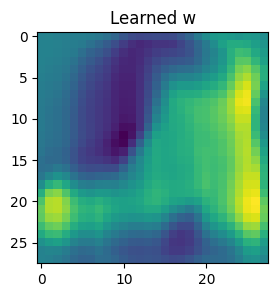

In [106]:
for classifier in my_svm.classifiers:
    plt.figure(figsize=(3,3))
    plt.imshow(np.reshape(classifier.w, [28, 28], order='F'))
    plt.title('Learned w')
    plt.show()

## TODO: Tune the parameter C to get at least 80% test accuracy

In [184]:
C = 4.281 
lambda_ = 1./C
my_svm = MulticlassLinearSVM(lambda_=lambda_, K_classes=10)

my_svm.fit(X_train_scaled, y_train, num_iter=10000, num_per_batch=64, verbose=True)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

Iter 5000/10000: cost = 0.18321845517904128  (0.0s)
Iter 10000/10000: cost = 0.18087049885345813  (0.0s)
Classifier 1/10: time (4.761831998825073s)
Classifier 1/10: time (4.761831998825073s)
Iter 5000/10000: cost = 0.09100373135522323  (0.0007579326629638672s)
Iter 10000/10000: cost = 0.09010518728145953  (0.0s)
Classifier 2/10: time (4.036244869232178s)
Classifier 2/10: time (4.036244869232178s)
Iter 5000/10000: cost = 0.2683278094559062  (0.0s)
Iter 10000/10000: cost = 0.26392552421718696  (0.0s)
Classifier 3/10: time (4.145524740219116s)
Classifier 3/10: time (4.145524740219116s)
Iter 5000/10000: cost = 0.1714170843332438  (0.0s)
Iter 10000/10000: cost = 0.1697977793587293  (0.0s)
Classifier 4/10: time (3.404047727584839s)
Classifier 4/10: time (3.404047727584839s)
Iter 5000/10000: cost = 0.2559038493822095  (0.0s)
Iter 10000/10000: cost = 0.25227889862570774  (0.0s)
Classifier 5/10: time (3.432086706161499s)
Classifier 5/10: time (3.432086706161499s)
Iter 5000/10000: cost = 0.13757

In [185]:
print('Found C = {}, lambda = {}'.format(C, lambda_)) 
print('Accuracy train: {}'.format(my_svm.score(X_train_scaled, y_train)))
print('Accuracy test: {}'.format(my_svm.score(X_test_scaled, y_test)))

Found C = 4.281, lambda = 0.233590282644242
Accuracy train: 0.8037916666666667
Accuracy test: 0.7970833333333334


## Part 2: SVM with RBF kernel

## Task 2.1: Compare RBF and linear kernels [10 points]

**TODO:** Compare SVM with linear and RBF kernels on toy datasets. Implement *plot_classifiers_predictions* function. Make sure to plot the decision regions as in the previous assignment as well as the support vectors.

**HINT:** You may use ideas from this [webpage](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py).


In [186]:
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons, make_circles, make_blobs

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
def plot_classifiers_predictions(X, y, classifiers):
    """
    Plots the decision regions and support vectors of the classifiers
    fit on X and y.

    Args:
        X: Data matrix of shape [num_train, num_features]
        y: Labels of shape [num_train]
        classifiers: A list of classfifier objects

    """

    fig, axes = plt.subplots(ncols=len(classifiers), nrows=1, figsize=(16, 8))

    for classifier, axis in zip(classifiers, axes.flat):
        #######################################################################
        # TODO:                                                               #
        # Implement the plotting function                                     # 
        #                                                                     #
        #######################################################################

        # Fit the classifier to the data

        # Plot the decision regions

        # Plot the support vectors

        #######################################################################
        #                         END OF YOUR CODE                            #
        #######################################################################
        
        axis.set_title('{}, accuracy = {:.2f}'.format(
            classifier.__class__.__name__, classifier.score(X, y)))

In [ ]:
from sklearn.svm import SVC

linear_svc = SVC(kernel="linear")
rbf_svc = SVC(kernel="rbf")

classifiers = [linear_svc, rbf_svc]

In [ ]:
X_blobs, y_blobs = make_blobs(n_samples=300, centers=[[-1.5, -1.5], [1.5, 1.5]])
plot_classifiers_predictions(X_blobs, y_blobs, classifiers)

In [ ]:
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=0)
plot_classifiers_predictions(X_moons, y_moons, classifiers)

In [ ]:
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, random_state=0, factor=0.6)
plot_classifiers_predictions(X_circles, y_circles, classifiers)

## Questions [6 points]

* Play with the hyperparameters. How do the hyper-parameters influence the classifier? What happens for extreme values of the hyper-parameters?

***Your Answer:***

* Linear SVM vs. Gaussian Kernel SVM: Give advantages and disadvantages of both approaches. 

***Your Answer: Advantages of linear SVM is that it is simple works for linarly seperable data, and is scalable - computationally efficient also for large datasets, also it is easy to interpret. The disadvantage of linear sVM would be that it has limited flexibility therefore might not caputre complex pattern that are not linearly seperable and also performance wise could might underperform copmared to kernel SVM. An advantage of using gaussian kernel sVM is therefore that it is more flexible and performs better on datasets where classes are not linearly seperable - model can be more complex - non-linear DB (desion boundry) disadvantages could however be that it is more computationaly costly especially for larger datasets - risk of overfitting (need tuned hyperapramaeters) and interpretebiliy is less than in linear models. It is important to notice that a SVM paramerter optimization problem is convex - so any local solution is also a global optimum, makes extensive use of Lagrange multipliers.***

* Linear SVM vs. Gaussian Kernel SVM: In what setting would you pick one method over the other? Answer in terms of number of training examples $m_{train}$ and feature dimension $d$

***Your Answer: Lienar SVM is good when data is high-dimensional/large nr. features and efficiency (computational) is important. The gaussian kernel SVM is better for datasets with complex pattern, where number of features is low compared to number of training examples***


## Part 3: Competition! [16 points + 20 bonus]

See the details of the competition in competition.ipynb  
Pay special attention to the part of beating the hard baseline **[16 points]**, since it is required to get a full grade for this assignment.